# Abstract

Kaggle dataset: https://www.kaggle.com/brandao/diabetes


We picked a publicly available dataset from UCI repository containing de-identified diabetes patient encounter data for 130 US hospitals (1999–2008) containing 101,766 observations over 10 years. The dataset has over 50 features including patient characteristics, conditions, tests and 23 medications. Only diabetic encounters are included (i.e. at least one of three primary diagnosis was diabetes).

Applied methods are:
* Cleaning tasks such as dropping bad data, dealing with missing values.
* Modification of existing features e.g. standardization, log transforms etc.
* Creation or derivation of new features, usually from existing ones.
* Graphs such as plots, heatmap have been used.



## Overview of Dataset

### Starting H2O server¶

In [1]:
# import h2o package and specific estimator 

import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import seaborn
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

### Required Data Parameters

* y: This argument is the name (or index) of the response column.
* training_frame: Specifies the training set.

### Required Stopping Parameters

* max_runtime_secs: This argument controls how long the AutoML run will execute for. This defaults to 3600 seconds (1 hour).
* max_models: Specify the maximum number of models to build in an AutoML run, excluding the Stacked Ensemble models. Defaults to NULL/None.


In [2]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [3]:
# 65535 Highest port no
port_no=random.randint(5555,55555)

 # start h2o
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o


Checking whether there is an H2O instance running at http://localhost:7599..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\joiss\AppData\Local\Temp\tmpueab2mg3
  JVM stdout: C:\Users\joiss\AppData\Local\Temp\tmpueab2mg3\h2o_joiss_started_from_python.out
  JVM stderr: C:\Users\joiss\AppData\Local\Temp\tmpueab2mg3\h2o_joiss_started_from_python.err
  Server is running at http://127.0.0.1:7599
Connecting to H2O server at http://127.0.0.1:7599... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,2 months and 27 days
H2O cluster name:,H2O_from_python_joiss_tmazgh
H2O cluster total nodes:,1
H2O cluster free memory:,4.792 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Data overview

In [4]:
# Import data and manage data types
train_path = "Dataset/diabetes_train.csv"
df = h2o.import_file(train_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
df.head(5)

id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2.27839e+06,8.22216e+06,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,nan,nan,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
64410,8.60479e+07,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,nan,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
500364,8.24424e+07,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,4.25193e+07,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
55842,8.42598e+07,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,nan,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
df.tail(5)

id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2.40242e+08,4.57489e+07,Caucasian,Male,[60-70),?,3,1,1,6,?,?,62,6,50,0,0,0,414,411,427,8,None,None,No,No,No,No,No,No,No,Steady,No,Steady,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
2.40251e+08,6.05036e+07,AfricanAmerican,Male,[20-30),?,1,1,7,3,OG,?,60,0,9,0,0,1,250.12,276,276,7,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
2.40257e+08,2.18105e+06,Caucasian,Female,[70-80),?,3,6,1,3,?,?,26,2,32,0,0,0,715,285,278,9,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
2.40257e+08,4.61461e+07,Caucasian,Male,[60-70),?,3,1,1,1,MC,?,34,1,21,0,0,0,414,428,276,9,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
2.40277e+08,3.42898e+07,Caucasian,Female,[60-70),?,1,1,7,1,BC,?,50,6,25,0,0,0,414,428,411,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
df.describe()

Rows:50001
Cols:50




,id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
type,int,int,enum,enum,enum,enum,int,int,int,int,enum,enum,int,int,int,int,int,int,real,real,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum
mins,12522.0,135.0,,,,,1.0,1.0,1.0,1.0,,,1.0,0.0,1.0,0.0,0.0,0.0,3.0,8.0,5.0,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mean,118350344.8944621,43491484.558948815,,,,,2.102177956440871,4.167336653266933,5.74982500349993,4.4368312633747315,,,42.90460190796182,1.385032299354013,15.681846363072736,0.25887482250355004,0.13165736685266294,0.523189536209276,493.62482470614606,432.29717529593415,412.4333165829146,7.069218615627688,,,,,,,,,,,,,,,,,,,,,,,,,,,,
maxs,240277404.0,115218477.0,,,,,8.0,28.0,22.0,14.0,,,132.0,6.0,81.0,36.0,28.0,21.0,999.0,999.0,999.0,9.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sigma,60444491.42445576,35065949.89381691,,,,,1.4867613986147448,5.808736341446589,4.316877484869778,3.0317477848441454,,,19.066150608395485,1.6987840249592443,8.459927673383218,0.9949384332461385,0.636463660455315,1.156783140720553,208.26118899894746,180.2259649013558,177.02506045996856,2.02268848007454,,,,,,,,,,,,,,,,,,,,,,,,,,,,
zeros,0,0,,,,,0,0,0,0,,,0,21844,0,43811,45948,35748,0,0,0,0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,912,1426,3435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2278392.0,8222157.0,Caucasian,Female,[0-10),?,6.0,25.0,1.0,1.0,?,Pediatrics-Endocrinology,41.0,0.0,1.0,0.0,0.0,0.0,250.83,nan,nan,1.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,64410.0,86047875.0,AfricanAmerican,Female,[20-30),?,1.0,1.0,7.0,2.0,?,?,11.0,5.0,13.0,2.0,0.0,1.0,648.0,250.0,nan,6.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364.0,82442376.0,Caucasian,Male,[30-40),?,1.0,1.0,7.0,2.0,?,?,44.0,1.0,16.0,0.0,0.0,0.0,8.0,250.43,403.0,7.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


In [8]:
# Assign target and inputs
y = "readmitted"
X = [name for name in df.columns if name != y]
print("y: ",y)
print("X: ", X)

y:  readmitted
X:  ['id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [9]:
# determine column types
ints, reals, enums = [], [], []
for key, val in df.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        elif val == 'int':
            ints.append(key)            
        else: 
            reals.append(key)

print("Integer columns:",ints,"\n")
print("Enum columns:", enums, "\n")
print("Real numbers: ",reals, "\n")

Integer columns: ['id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'] 

Enum columns: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'] 

Real numbers:  ['diag_1', 'diag_2', 'diag_3'] 



# Feature Engineering


In [10]:
print('Number of samples:', df.shape)

Number of samples: (50001, 50)


* Since, admission_type_id', 'discharge_disposition_id', 'admission_source_id' are multi-class columns and are more of Ids ie, enum than integres, we are converting them into "enums". 

* Also, diag_1, diag_2, diag_3 are enum and not suited to be real numbers 

In [11]:
#Convert to enums

for j in ["admission_type_id", "discharge_disposition_id", "admission_source_id",
          "diag_1", "diag_2", "diag_3"]:
    df[j] = (df[j].ascharacter()).asfactor()
df = h2o.assign(df, "diabetes_train")

In [12]:
# determine column types
ints, reals, enums = [], [], []
for key, val in df.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        elif val == 'int':
            ints.append(key)            
        else: 
            reals.append(key)

print("Integer columns:",ints,"\n")
print("Enum columns:", enums, "\n")
print("Real numbers: ",reals, "\n")

Integer columns: ['id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'] 

Enum columns: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'] 

Real numbers:  [] 



In [13]:
df["readmitted"].head(3)

readmitted
NO
NO
NO


In [14]:
df["readmitted"].nlevels()

[2]

In [15]:
df["readmitted"].categories()

['<30', 'NO']

In [16]:
#one-hot encoding: 0 if No, 1 is <30 days 
df["readmitted"]=df["readmitted"].set_levels(["1","0"])

In [17]:
df["readmitted"].categories()

['1', '0']

In [18]:
# Set target and predictor variables
y = "readmitted"
x = df.col_names
x.remove(y)
x.remove("id")
x.remove("patient_nbr")
x.remove("discharge_disposition_id")
x.remove("admission_source_id")
x.remove("payer_code")
print("Df colnames: ", x)

Df colnames:  ['race', 'gender', 'age', 'weight', 'admission_type_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [19]:
df.isna()

isNA(id),isNA(patient_nbr),isNA(race),isNA(gender),isNA(age),isNA(weight),isNA(admission_type_id),isNA(discharge_disposition_id),isNA(admission_source_id),isNA(time_in_hospital),isNA(payer_code),isNA(medical_specialty),isNA(num_lab_procedures),isNA(num_procedures),isNA(num_medications),isNA(number_outpatient),isNA(number_emergency),isNA(number_inpatient),isNA(diag_1),isNA(diag_2),isNA(diag_3),isNA(number_diagnoses),isNA(max_glu_serum),isNA(A1Cresult),isNA(metformin),isNA(repaglinide),isNA(nateglinide),isNA(chlorpropamide),isNA(glimepiride),isNA(acetohexamide),isNA(glipizide),isNA(glyburide),isNA(tolbutamide),isNA(pioglitazone),isNA(rosiglitazone),isNA(acarbose),isNA(miglitol),isNA(troglitazone),isNA(tolazamide),isNA(examide),isNA(citoglipton),isNA(insulin),isNA(glyburide-metformin),isNA(glipizide-metformin),isNA(glimepiride-pioglitazone),isNA(metformin-rosiglitazone),isNA(metformin-pioglitazone),isNA(change),isNA(diabetesMed),isNA(readmitted)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
predictors=df[x]
type(predictors)

h2o.frame.H2OFrame

In [21]:
predictors.shape

(50001, 44)

In [64]:
response=y

### Finding Co-realtion among columns

In [23]:
df_cor_cols=df[ints]

In [24]:
df_cor_cols.columns

['id',
 'patient_nbr',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [25]:
df_cor_cols=df_cor_cols.drop("id")
df_cor_cols=df_cor_cols.drop("patient_nbr")

In [26]:
df_cor_cols.columns

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

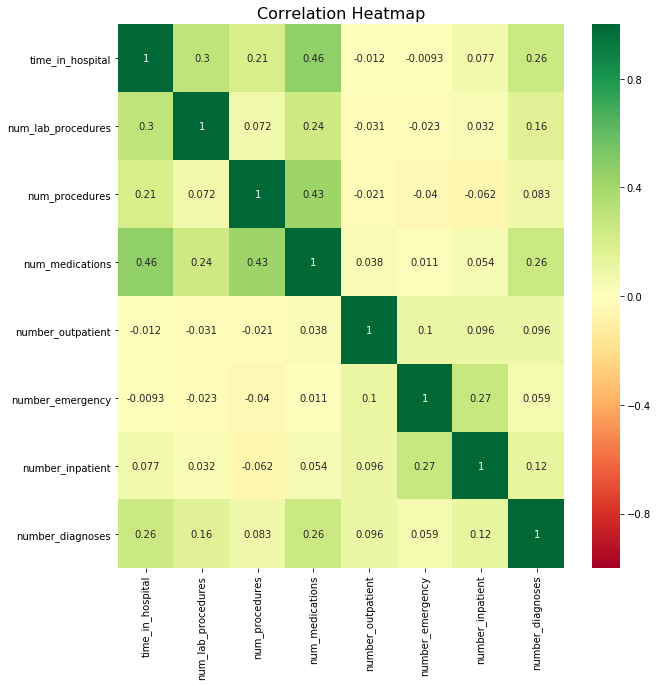

In [27]:
plt.figure(figsize=(10,10))
corr = df_cor_cols.cor().as_data_frame()
corr.index = df_cor_cols.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

## Meta data

In [28]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=y
nthreads=1 
min_mem_size=6 
run_time=500
classification=True
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [29]:
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
    m_data={}
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['server_path']=server
    m_data['data_path']=data 
    m_data['test_path']=test
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['run_id'] =run_id
    m_data['scale']=scale
    m_data['classification']=classification
    m_data['scale']=False
    m_data['model_path']=model_path
    m_data['balance']=balance
    m_data['balance_threshold']=balance_threshold
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['run_path'] =path
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    m_data['analysis'] = analysis
    return m_data


In [30]:
def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()

In [31]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str

In [32]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)





RZ6eBS7mp


In [33]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555902585.2259562, 'target': 'readmitted', 'server_path': 'C:\\Users\\joiss\\Desktop\\NEU-MSIS\\2_Sem2\\INFO6105_Data_Science_Engineering_Methods\\0_HyperParameter\\0_DS01_HyperParameter', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 500, 'run_id': 'RZ6eBS7mp', 'scale': False, 'classification': True, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555902585.2259562, 'execution_time': 0.0, 'run_path': 'C:\\Users\\joiss\\Desktop\\NEU-MSIS\\2_Sem2\\INFO6105_Data_Science_Engineering_Methods\\0_HyperParameter\\0_DS01_HyperParameter\\RZ6eBS7mp', 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [34]:
meta_data_startTime_beforeModelEval= time.asctime(time.localtime(meta_data["start_time"])) 
print("meta_data_startTime_beforeModelEval: ",meta_data_startTime_beforeModelEval)

meta_data_startTime_beforeModelEval:  Sun Apr 21 23:09:45 2019


In [35]:
meta_data_endTime_beforeModelEval= time.asctime( time.localtime(meta_data["end_time"]) )
print( "meta_data_endTime_beforeModelEval= ", meta_data_endTime_beforeModelEval)

meta_data_endTime_beforeModelEval=  Sun Apr 21 23:09:45 2019


In [36]:
# Add independent variables

meta_data['X']=predictors.columns 

In [37]:
meta_data['variables']=df.columns

In [38]:
type(predictors)
independentVars_df=predictors.as_data_frame()

In [39]:
# save the changed dataset
dataset_stats=run_id+'_independentVariables.csv'
independentVars_df.to_csv(dataset_stats, index=False)

## Train model using h2o

In [40]:
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
#train, valid, test = df.split_frame(ratios=[0.7, 0.15], seed=42)

In [41]:
# Use Auto ML to train models
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs = run_time,project_name = name)

In [42]:
model_start_time = time.time()

In [43]:
aml.train(x = predictors.columns, y = y, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [44]:
meta_data['model_execution_time'] = time.time() - model_start_time

## Print Leaderboard

In [45]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190421_230946,0.709219,0.423215,0.460722,0.36232,0.131275
StackedEnsemble_BestOfFamily_AutoML_20190421_230946,0.708877,0.423798,0.465452,0.362477,0.131389
GLM_grid_1_AutoML_20190421_230946_model_1,0.704824,0.425356,0.465952,0.363453,0.132098
GBM_grid_1_AutoML_20190421_230946_model_4,0.700568,0.436165,0.474008,0.368526,0.135812
GBM_grid_1_AutoML_20190421_230946_model_3,0.699463,0.447776,0.47683,0.373958,0.139845
DeepLearning_1_AutoML_20190421_230946,0.699055,0.427244,0.460595,0.363604,0.132208
GBM_grid_1_AutoML_20190421_230946_model_5,0.696071,0.437804,0.473283,0.369191,0.136302
GBM_grid_1_AutoML_20190421_230946_model_2,0.696011,0.437853,0.46835,0.369297,0.13638
DRF_1_AutoML_20190421_230946,0.682035,0.443376,0.477724,0.367459,0.135026
DeepLearning_grid_1_AutoML_20190421_230946_model_1,0.676344,0.440589,0.474237,0.367737,0.135231


In [46]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190421_230946
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.10841482462978803
RMSE: 0.32926406519659573
LogLoss: 0.36149126623486777
Null degrees of freedom: 50000
Residual degrees of freedom: 49994
Null deviance: 46755.46076076399
Residual deviance: 36149.84960601925
AIC: 36163.84960601925
AUC: 0.8628894203100573
pr_auc: 0.9633836892153087
Gini: 0.7257788406201147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.591627868620706: 


,1,0,Error,Rate
1,2930.0,5944.0,0.6698,(5944.0/8874.0)
0,1308.0,39819.0,0.0318,(1308.0/41127.0)
Total,4238.0,45763.0,0.145,(7252.0/50001.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5916279,0.9165382,254.0
max f2,0.2260959,0.9604639,360.0
max f0point5,0.7387083,0.9142795,178.0
max accuracy,0.6541446,0.8565429,226.0
max precision,0.9407888,1.0,0.0
max recall,0.0850338,1.0,391.0
max specificity,0.9407888,1.0,0.0
max absolute_mcc,0.7387083,0.5032438,178.0
max min_per_class_accuracy,0.7825118,0.7861016,145.0
max mean_per_class_accuracy,0.7790480,0.7869832,148.0


Gains/Lift Table: Avg response rate: 82.25 %, avg score: 78.95 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100198,0.9296588,1.2157707,1.2157707,1.0,0.9333763,1.0,0.9333763,0.0121818,0.0121818,21.5770662,21.5770662
,2,0.0200196,0.9255121,1.2157707,1.2157707,1.0,0.9273769,1.0,0.9303796,0.0121575,0.0243392,21.5770662,21.5770662
,3,0.0300194,0.9226721,1.2157707,1.2157707,1.0,0.9240285,1.0,0.9282640,0.0121575,0.0364967,21.5770662,21.5770662
,4,0.0400192,0.9202543,1.2157707,1.2157707,1.0,0.9213599,1.0,0.9265388,0.0121575,0.0486542,21.5770662,21.5770662
,5,0.0500190,0.9178805,1.2133391,1.2152845,0.998,0.9190412,0.9996002,0.9250399,0.0121331,0.0607873,21.3339120,21.5284548
,6,0.1000180,0.9075125,1.2084760,1.2118810,0.994,0.9124495,0.9968006,0.9187460,0.0604226,0.1212099,20.8476038,21.1880973
,7,0.1500170,0.8986329,1.1987499,1.2075045,0.986,0.9030284,0.9932009,0.9135075,0.0599363,0.1811462,19.8749872,20.7504523
,8,0.2000160,0.8901473,1.1953457,1.2044651,0.9832,0.8944464,0.9907009,0.9087427,0.0597661,0.2409123,19.5345714,20.4465125
,9,0.3000140,0.8724342,1.1797839,1.1962386,0.9704,0.8813685,0.9839344,0.8996186,0.1179760,0.3588883,17.9783850,19.6238582
,10,0.4000120,0.8529825,1.1544958,1.1858034,0.9496,0.8628914,0.9753512,0.8904372,0.1154473,0.4743356,15.4495820,18.5803413




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.13127546111475105
RMSE: 0.362319556627504
LogLoss: 0.42321474090078165
Null degrees of freedom: 50000
Residual degrees of freedom: 49994
Null deviance: 46759.387902365175
Residual deviance: 42322.320519559966
AIC: 42336.320519559966
AUC: 0.7092192533405994
pr_auc: 0.9094856854672794
Gini: 0.41843850668119886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4103760333347033: 


,1,0,Error,Rate
1,775.0,8099.0,0.9127,(8099.0/8874.0)
0,361.0,40766.0,0.0088,(361.0/41127.0)
Total,1136.0,48865.0,0.1692,(8460.0/50001.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4103760,0.9059916,326.0
max f2,0.1459498,0.9588587,385.0
max f0point5,0.7155690,0.8698942,212.0
max accuracy,0.4744618,0.8311434,308.0
max precision,0.9454963,1.0,0.0
max recall,0.0591257,1.0,397.0
max specificity,0.9454963,1.0,0.0
max absolute_mcc,0.7155690,0.2550669,212.0
max min_per_class_accuracy,0.8432848,0.6477010,111.0
max mean_per_class_accuracy,0.8401833,0.6494622,114.0


Gains/Lift Table: Avg response rate: 82.25 %, avg score: 82.25 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100198,0.9343887,1.1842237,1.1842237,0.9740519,0.9378218,0.9740519,0.9378218,0.0118657,0.0118657,18.4223718,18.4223718
,2,0.0200196,0.9307854,1.1817291,1.1829776,0.972,0.9324226,0.9730270,0.9351249,0.0118171,0.0236827,18.1729083,18.2977647
,3,0.0300194,0.9282860,1.1695714,1.1785119,0.962,0.9294552,0.9693538,0.9332363,0.0116955,0.0353782,16.9571376,17.8511867
,4,0.0400192,0.9260779,1.1622768,1.1744551,0.956,0.9271180,0.9660170,0.9317074,0.0116225,0.0470008,16.2276752,17.4455117
,5,0.0500190,0.9241634,1.1476875,1.1691037,0.944,0.9250839,0.9616154,0.9303833,0.0114766,0.0584774,14.7687505,16.9103735
,6,0.1000180,0.9166285,1.1520643,1.1605857,0.9476,0.9202805,0.9546091,0.9253329,0.0576021,0.1160795,15.2064279,16.0585711
,7,0.1500170,0.9101498,1.1345572,1.1519107,0.9332,0.9133578,0.9474737,0.9213417,0.0567267,0.1728062,13.4557181,15.1910691
,8,0.2000160,0.9038277,1.1185090,1.1435611,0.92,0.9070269,0.9406059,0.9177634,0.0559243,0.2287305,11.8509009,14.3561105
,9,0.3000140,0.8909168,1.0992998,1.1288083,0.9042,0.8974666,0.9284714,0.9109982,0.1099278,0.3386583,9.9299832,12.8808331
,10,0.4000120,0.8765264,1.0720666,1.1146236,0.8818,0.8839023,0.9168042,0.9042246,0.1072045,0.4458628,7.2066569,11.4623600


In [47]:

# get leaderboard in data frame
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [48]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,StackedEnsemble_AllModels_AutoML_20190421_230946,0.709219,0.423215,0.460722,0.362320,0.131275
1,StackedEnsemble_BestOfFamily_AutoML_20190421_2...,0.708877,0.423798,0.465452,0.362477,0.131389
2,GLM_grid_1_AutoML_20190421_230946_model_1,0.704824,0.425356,0.465952,0.363453,0.132098
3,GBM_grid_1_AutoML_20190421_230946_model_4,0.700568,0.436165,0.474008,0.368526,0.135812
4,GBM_grid_1_AutoML_20190421_230946_model_3,0.699463,0.447776,0.476830,0.373958,0.139845
5,DeepLearning_1_AutoML_20190421_230946,0.699055,0.427244,0.460595,0.363604,0.132208
6,GBM_grid_1_AutoML_20190421_230946_model_5,0.696071,0.437804,0.473283,0.369191,0.136302
7,GBM_grid_1_AutoML_20190421_230946_model_2,0.696011,0.437853,0.468350,0.369297,0.136380
8,DRF_1_AutoML_20190421_230946,0.682035,0.443376,0.477724,0.367459,0.135026
9,DeepLearning_grid_1_AutoML_20190421_230946_mod...,0.676344,0.440589,0.474237,0.367737,0.135231


In [49]:
# save all models names of the leaderboard in a csv
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats, index=False)

In [50]:
# All models. We are no longer using the best model
meta_data['models']=aml_leaderboard_df['model_id']

In [51]:
meta_data['end_time'] = time.time()

In [52]:
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']

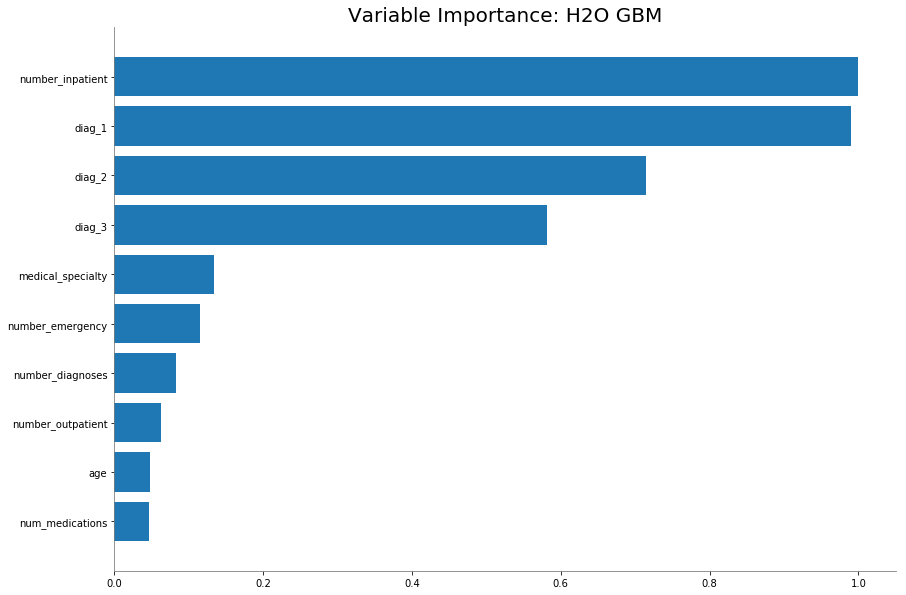

In [53]:
### Variable importance based on models

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

sample_model1=h2o.get_model(aml_leaderboard_df['model_id'][4]) 
sample_model1.varimp_plot()

### Convert Meta-data into JSON/ Csv Files

In [54]:
meta_data

{'start_time': 1555902585.2259562,
 'target': 'readmitted',
 'server_path': 'C:\\Users\\joiss\\Desktop\\NEU-MSIS\\2_Sem2\\INFO6105_Data_Science_Engineering_Methods\\0_HyperParameter\\0_DS01_HyperParameter',
 'data_path': None,
 'test_path': None,
 'max_models': 9,
 'run_time': 500,
 'run_id': 'RZ6eBS7mp',
 'scale': False,
 'classification': True,
 'model_path': None,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1555903100.6097195,
 'execution_time': 515.3837633132935,
 'run_path': 'C:\\Users\\joiss\\Desktop\\NEU-MSIS\\2_Sem2\\INFO6105_Data_Science_Engineering_Methods\\0_HyperParameter\\0_DS01_HyperParameter\\RZ6eBS7mp',
 'nthreads': 1,
 'min_mem_size': 6,
 'analysis': 0,
 'X': ['race',
  'gender',
  'age',
  'weight',
  'admission_type_id',
  'time_in_hospital',
  'medical_specialty',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency',
  'number_inpatient',
  'diag_1',
  'diag_2',
  'diag_3',
  'n

In [55]:
type(meta_data)

dict

In [56]:
##converting meta data into csv files

## A list of the keys of dictionary. Convert dictionary to list and then into panda Dataframe. Save the dataframe in a csv file.

#list_keys = [ k for k in meta_data ]
 
## or a list of the values
#list_values = [ v for v in meta_data.values() ]
 
## or just a list of the list of key value pairs
#list_key_value = [ [k,v] for k, v in meta_data.items() ]

#metaData_stats=run_id+'_metadata.csv'
#df1 = pd.DataFrame(list_key_value)
#df1.to_csv(metaData_stats)

## Find all parameters for all the models in the aml leaderboard

In [57]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,StackedEnsemble_AllModels_AutoML_20190421_230946,0.709219,0.423215,0.460722,0.362320,0.131275
1,StackedEnsemble_BestOfFamily_AutoML_20190421_2...,0.708877,0.423798,0.465452,0.362477,0.131389
2,GLM_grid_1_AutoML_20190421_230946_model_1,0.704824,0.425356,0.465952,0.363453,0.132098
3,GBM_grid_1_AutoML_20190421_230946_model_4,0.700568,0.436165,0.474008,0.368526,0.135812
4,GBM_grid_1_AutoML_20190421_230946_model_3,0.699463,0.447776,0.476830,0.373958,0.139845
5,DeepLearning_1_AutoML_20190421_230946,0.699055,0.427244,0.460595,0.363604,0.132208
6,GBM_grid_1_AutoML_20190421_230946_model_5,0.696071,0.437804,0.473283,0.369191,0.136302
7,GBM_grid_1_AutoML_20190421_230946_model_2,0.696011,0.437853,0.468350,0.369297,0.136380
8,DRF_1_AutoML_20190421_230946,0.682035,0.443376,0.477724,0.367459,0.135026
9,DeepLearning_grid_1_AutoML_20190421_230946_mod...,0.676344,0.440589,0.474237,0.367737,0.135231


In [58]:
# How to access the first model name in the data frame w/o index

print("First Model: ", aml_leaderboard_df['model_id'][0])  

First Model:  StackedEnsemble_AllModels_AutoML_20190421_230946


In [59]:
#declaring a dictionary to hold all the parameters for all the models predicted by the aml leaderboard
leaderboard_params={}
type(leaderboard_params)

dict

In [61]:
## for loop is used to store the model_id and it's corresponding parameters in a dictionary.
    ## Stores on the parameters. Not the hyper parameters. For all models in the leaderboard. 


for i in range(0, len(aml_leaderboard_df)):
    modelName= aml_leaderboard_df['model_id'][i]
    testModel=h2o.get_model(modelName)
    v_file=testModel.params
    n=run_id+'_'+testModel.model_id+'_nonhy_parameter.json'
    dict_to_json(v_file,n)

In [73]:
## Plot Learning curve for parameters
gbm1= h2o.get_model(aml_leaderboard_df['model_id'][4])

In [75]:
type(gbm1)

h2o.estimators.gbm.H2OGradientBoostingEstimator

In [81]:
gbmLogloss=gbm1.logloss()
gbmLogloss

0.4366113576133691

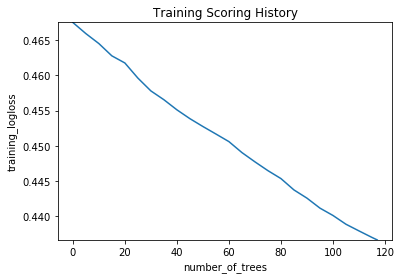

In [82]:
gbm1.plot()

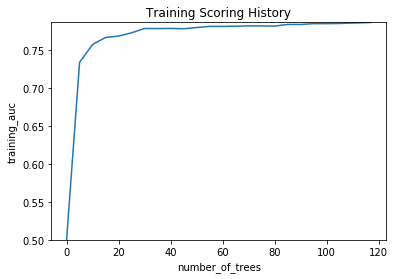

In [86]:
gbm1.plot(metric='auc')

## Find the best Hyperparameters

Hyperparameters for GBM are as follows:

* n-trees : Build more trees so as to increase the validation set error
* learn_rate: Ideally, should be less. Make learn_rate= 0.02. 
* learn_rate_annealing: Reduce learning rate with addition of each tree. Make learn_rate_annealing=0.995.
    * To make it faster, make learn rate=0.05 and learn_rate_annealing=0.99
* max_depth: Deeper  trees takes longer to train. Keep this less than 10.
* sample_rate: Row sampling. Ideally, sample (70-80 percent of the data), ie, 0.7-0.8
* col_sample_rate: Column sampling.

Hyperparameters for Random Forest is as follows:
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

### Use grid search to find the best hyperparameters

## Create JSON files for Hyperparameter

In [ ]:
## for loop is used to store the model_id and it's corresponding parameters in a dictionary

### Use this while finding hyperparameter cause "n" will have hy_parameter.json extension.

#for i in range(0, len(aml_leaderboard_df)):
  #  modelName= aml_leaderboard_df['model_id'][i]
   # testModel=h2o.get_model(modelName)
   # v_file=testModel.params
    #n=run_id+'_'+testModel.model_id+'_hy_parameter.json'
    #dict_to_json(v_file,n)

## We try to check the plot between hyperparameter against its values to know the best value range.

## Hyperparameters importance plot

#### Plot Learning Curve

## Last step

In [ ]:
# in case of server error, run this.
h2o.cluster().shutdown()

# Citations
* https://www.hindawi.com/journals/bmri/2014/781670/
* https://www.kaggle.com/sudalairajkumar/getting-started-with-h2o
* https://www.pythonforbeginners.com/dictionary/how-to-use-dictionaries-in-python/
* https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb
* http://h2o-release.s3.amazonaws.com/h2o/master/3233/docs-website/h2o-py/docs/h2o.model.html

# Team Members:
Team Name: DS01
 * Michelle Pradeep
     * NUID: 001422140
     * E-mail ID: pradeep.m@husky.neu.edu
 * Seemanthini Jois
      * NUID: 001439942
      * E-mail ID: jois.s@husky.neu.edu
 * Suraksha Jadhav
      * NUID: 001430368
      * E-mail ID: jadhav.su@husky.neu.edu

# The MIT License


Copyright (c)  2019 DS01

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.